Fractal dimention could give some estimate of roughness , which could be used for multiple reasons 

https://thescipub.com/pdf/jcssp.2018.1081.1096.pdf --> uses fractal dimention for lung sound classification

https://ieeexplore.ieee.org/abstract/document/1531657 --> uses variance fractal dimention to segment heart sounds 



In [40]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(1, module_path + '/src')

import utility
import matplotlib.pyplot as plt

import os
names = []
files_path = '/home/andrine/Desktop/dataTromso/Hasse413/'
names_full = os.listdir(files_path)
for n in names_full:
    if '_lungelyd_' in n:
        names.append(n)
        
X = pd.read_stata('/home/andrine/Desktop/dataTromso/hasse_413_ut.dta')
X_no_nan = X.dropna(thresh=1, axis=1)

cols = []

for col in X_no_nan:
    if np.any(X_no_nan[col] != ''):
        cols.append(col)
    else:
        continue 
        
X_no_nan = X_no_nan[cols]

del X
del names_full
del cols
        
lowcut = 25
highcut = 2400
FRAME_RATE = 5000
target_rate = 44100

from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.signal import stft

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=6)

In [37]:
map_wav = {
    '1': 'a',
    '2': 'b',
    '3': 'c',
    '4': 'd',
    '5': 'e',
    '6': 'f'
}

abnormalities = ['insp_wheeze', 'exp_wheeze', 'insp_crackle', 'exp_crackle']

def get_precence_columns(label, wav):
    map_wav = {
        '1': 'a',
        '2': 'b',
        '3': 'c',
        '4': 'd',
        '5': 'e',
        '6': 'f'
    }
    
    i = map_wav[wav]
    
    
    multiple_present = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_number_insp_t72', f'sub_{i}_ob1_i_wh_number_insp_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_number_exp_t72', f'sub_{i}_ob1_e_wh_number_exp_t72'],
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_number_insp_t72', f'sub_{i}_ob1_i_cr_number_insp_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_number_exp_t72', f'sub_{i}_ob1_e_cr_number_exp_t72']}
    if label not in multiple_present.keys():
        return None
    return multiple_present[label]



def get_column_observer_wav_file(observer, wav):    
    i = map_wav[wav]
    classify_dict = {
        'a' : [f'lung{i}_abnormal_sound_a_t72',
        f'lung{i}_insp_wheeze_a_t72',
        f'lung{i}_exp_wheeze_a_t72',
        f'lung{i}_insp_crackle_a_t72',
        f'lung{i}_exp_crackle_a_t72',
        f'lung{i}_other_abnorm_sound_a_t72',
        f'lung{i}_not_classifiable_a_t72'],

        'b' :  [f'lung{i}_abnormal_sound_b_t72',
        f'lung{i}_insp_wheeze_b_t72',
        f'lung{i}_exp_wheeze_b_t72',
        f'lung{i}_insp_crackle_b_t72',
        f'lung{i}_exp_crackle_b_t72',
        f'lung{i}_other_abnorm_sound_b_t72',
        f'lung{i}_not_classifiable_b_t72'],


        'c' : [f'lung{i}_abnormal_sound_c_t72',
        f'lung{i}_insp_wheeze_c_t72',
        f'lung{i}_exp_wheeze_c_t72',
        f'lung{i}_insp_crackle_c_t72',
        f'lung{i}_exp_crackle_c_t72',
        f'lung{i}_other_abnorm_sound_c_t72',
        f'lung{i}_not_classifiable_c_t72']
    }
    
    return classify_dict[observer]

def get_second_round_eval(X, idx, label, wav):
    if label not in abnormalities: # Return True if there is no abnormality present
        return True
    i = map_wav[wav]
    
    second_round_res = {
        0 : 'not evaluated',
        1 : 'present',
        2 : 'absent', 
        3 : 'uncertain'
    }

    second_round_pres =  {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_presence_t72', f'sub_{i}_ob1_i_wh_presence_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_presence_t72', f'sub_{i}_ob1_e_wh_presence_t72'],
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_presence_t72', f'sub_{i}_ob1_i_cr_presence_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_presence_t72', f'sub_{i}_ob1_e_cr_presence_t72']}

    round2 = X.iloc[idx][second_round_pres[label]].values[0].astype(int)
    
    if (round2[0] == 2) or (round2[1] == 2): # Return False if second round of observers concluded absent 
        return False
    else:
        return True


def get_filename_label_map():
    annotation_list = ['abnormal_sound', 'insp_wheeze',
                       'exp_wheeze', 'insp_crackle', 'exp_crackle',
                      'other', 'not_classifiable']

    count = 0
    error_in_data = {}
    data = pd.DataFrame({'id':[] , 'nr': [],'label':[]})
    for n in names:
        i = n[0:8]
        try:
            wav = n.split('.')[0][-1]
        except IndexError as error:
            print(n)
            continue
        row_nr = np.where(X_no_nan['unikt_lopenr'] == i)[0] 
        a_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('a', wav)].values[0]
        b_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('b', wav)].values[0]

        if np.any(a_obs != b_obs):  # Check that observer a and observer b agree
            c_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('c', wav)].values[0]
        else:
            c_obs = a_obs


        if (c_obs[0] == 0) or (np.isnan(c_obs[0])):
            label = 'normal'
        else:
            try:
                label_idx = np.where(c_obs == 1.)[0]
                label = annotation_list[label_idx[1]]
                if len(label_idx) > 2: # Do not include samples with more than type of abnormality
                    error_in_data[n] = 'more than one abnormality'
                    count = count + 1
                    continue
            except IndexError as error:
                error_in_data[n] = 'IndexError'

        if not get_second_round_eval(X_no_nan, row_nr, label, wav): # If the second round of observers have concluded absent
            count = count + 1
            continue
            
        cols = get_precence_columns(label, wav)
        
        if cols != None: # Filtering to be sure that there appears more than one abnormality during the 15 s
            votes = X_no_nan.iloc[row_nr][cols].values[0]
            votes = votes[0] + votes[1]
            if votes < 3: 
                count = count + 1
                continue
                
                
        audio_file = files_path + n        
        data = data.append(pd.DataFrame({'id': [audio_file],'nr': [i] ,'label': [label]}))
    return error_in_data , data, count

In [41]:
error, data, count = get_filename_label_map()

.15916931_lungelyd_5.wav.f4Tk8a


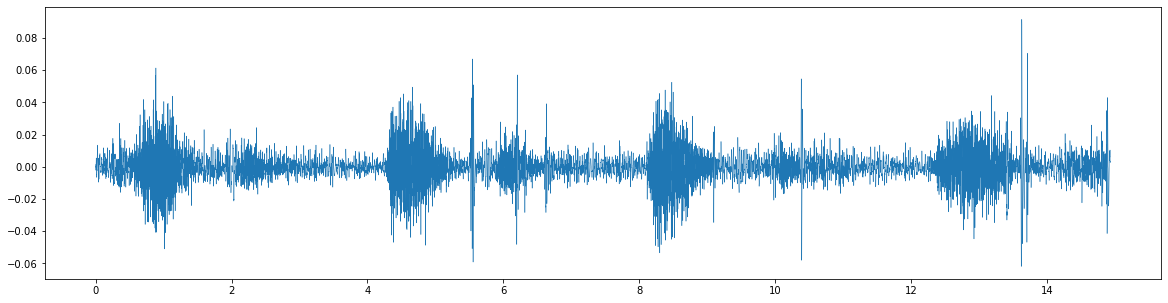

In [26]:
audio_file = files_path + names[0]

sr, audio = utility.read_wav_file(audio_file, target_rate)
audio = utility.denoise_audio(audio)
audio, sr = utility.downsample(audio, sr, 5000), 5000

f, ax = plt.subplots(1,1)
f.set_size_inches(20, 5)


duration = float(len(audio)) / sr
T = 1.0/sr
N = int(duration / T)
x = np.linspace(0.0, N*T, N +1 )

if len(x) != len(audio):
    x = np.linspace(0.0, N*T, N)

ax.plot(x, audio, linewidth = 0.5)

Filtering out the frequencies under 25 Hz

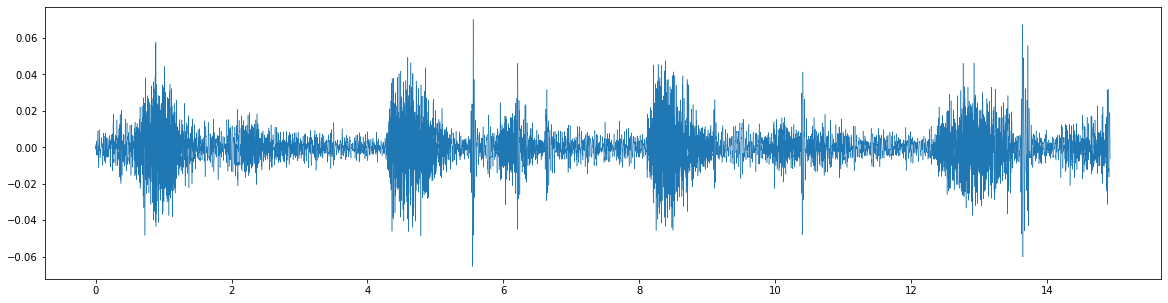

In [28]:
filtered = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')

f, ax = plt.subplots(1,1)
f.set_size_inches(20, 5)


duration = float(len(filtered)) / sr
T = 1.0/sr
N = int(duration / T)
x = np.linspace(0.0, N*T, N +1 )

if len(x) != len(audio):
    x = np.linspace(0.0, N*T, N)

ax.plot(x, filtered, linewidth = 0.5)

In [47]:
from antropy import petrosian_fd, katz_fd, higuchi_fd, detrended_fluctuation
from numpy import apply_along_axis as aal

pfd = petrosian_fd(audio[:33000])
ka =  katz_fd(audio[:33000])
hf = higuchi_fd(audio[:33000])

print(pfd)
print(ka)
print(hf)

1.0036258181394373
2.5422408187518384
1.199295717300471


calculating average fractal dimention of normal lung sounds 

In [ ]:
def zero_pad(ts, fixed_len):
    df_new = np.zeros(fixed_len)
    len_ts = len(ts)
    pad = (fixed_len - len_ts)//2
    df_new[pad:pad + len_ts] = ts
    return df_new

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

tot = np.array([])
for idx, row in data[data['label'] == 'normal'].iterrows():
    audio_file = row['id']
    try:
        sr, audio = utility.read_wav_file(audio_file, target_rate)
    except:
        continue
    audio = utility.denoise_audio(audio)
    audio, sr = utility.downsample(audio, sr, 5000), 5000
    audio = znorm(audio)
    if len(audio) >= 75000:
        audio = audio[:74999]
    audio = zero_pad(audio, 75000)
    tot = np.append(audio, tot)

In [43]:
pfd = petrosian_fd(audio)
ka =  katz_fd(audio)
hf = higuchi_fd(audio)

print(pfd)
print(ka)
print(hf)

1.0031390642652842
2.595286414716723
1.1904619910744065
